# NEURON Tutorial - Introduction

____
Authors of this script:

Elisabetta Iavarone @ Blue Brain Project

Werner Van Geit @ Blue Brain Project

Eilif Muller @ Blue Brain Project
____

## Introduction

In this notebook we will see some the main functionalities of the NEURON simulator.
We will see how to:
* Build a single compartment neuron model
* Add membrane mechanisms (such as ion currents)
* Create stimuli and run simulations
* Extend a single comparment model with dendrites

You can find part of this notebook in [this repository](https://github.com/BlueBrain/MOOC-neurons-and-synapses-2017). It supports the [Massive Open Online Course (MOOC) Simulation Neuroscience - reconstruction of a single neuron](https://actu.epfl.ch/news/mooc-simulation-neuroscience-reconstruction-of-a-s/).



In [2]:
# Show matplotlib plots inline
%matplotlib inline

# Import the Python NEURON module
# You can see the effect of this call in your terminal window
import neuron

# Load external files
neuron.h.load_file("stdrun.hoc");

## Construction a single compartment

The building blocks of a cell in NEURON are cylinders (called **segments** or **compartments**). Different segments between branch points are grouped together in a **section**.

Let's by creating a single somatic section, i.e. a Python object representing a section.

In [3]:
soma = neuron.h.Section(name='soma') # Specifying a name is not mandatory
print soma

This object has some attributes attached to it.

In [4]:
print dir(soma)

['L', 'Ra', '__call__', '__class__', '__delattr__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__iter__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'allseg', 'cell', 'children', 'connect', 'hname', 'hoc_internal_name', 'insert', 'name', 'nseg', 'orientation', 'parentseg', 'push', 'rallbranch', 'same', 'trueparentseg']


For example, a NEURON section has some default values:
* For the shape: section length ($L$), diameter ($diam$), number of segments ($nseg$) 
* Electical properties: specific axial resistance ($R_a$) and specific capacitance ($C_m$)

We can access and change these defaults.

Also, it's important to know the [units](https://www.neuron.yale.edu/neuron/static/docs/units/unitchart.html) NEURON uses as default.     

In [5]:
print r"Soma lenght is {} μm".format(soma.L)
print r"Soma diameter is {} μm".format(soma.diam)
print r"Soma has {} segment".format(soma.nseg)
print r"Soma axial resistance is {} Ωcm".format(soma.Ra)
print r"Soma axial resistance is {} μF/cm^2".format(soma.cm)

soma.L = soma.diam = 60
print "\nNow soma length is {} μm and its diameter is {} μm".format(soma.L, soma.diam) 

Soma lenght is 100.0 μm
Soma diameter is 500.0 μm
Soma has 1 segment
Soma axial resistance is 35.4 Ωcm
Soma axial resistance is 1.0 μF/cm^2

Now soma length is 60.0 μm and its diameter is 60.0 μm


## Adding membrane mechanisms

NEURON has a built-in Hodgkin and Huxley  mechanism, consisting of two active (i.e. voltage-dependent) currents (sodium and potassium, $I_{Na}$ and $I_{K}$) and a passive one (i.e. voltage-indipendent), which is the leak current ($I_{leak}$). These are the currents described in the [Hodgkin and Huxley (HH) model](https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model). The HH mechanism is one example of the so-called **distributed mechanisms** in NEURON, i.e. mechanisms that can be inserted in a section.

Now we are going to add just the leak current, thus we'll set Na$^+$ and K$^+$ to 0 $S/cm{^2}$. 



In [6]:
soma.insert("hh");
soma.gkbar_hh = 0.0 # S/cm^2
soma.gnabar_hh = 0.0 # S/cm^2
soma.el_hh = -70 # mV

In this condition, our section will behave as a RC circuit: the membrane resistance $R_m$ is the inverse of our leak conductance ($g_{leak}$): 

$$ R_m = 1 / g_{leak}$$ 

The membrane capacitance $C$ is the specific capacitance we have seen above multiplied by the section surface area ($S_{soma}$):

$$C=C_m S_{soma}$$

Let's see how to charge our membrane capacitance.

## Injecting a current and running a simulation

We now stick a virtual electrode in the soma to simulate a [current-clamp](http://vlab.amrita.edu/?sub=3&brch=43&sim=132&cnt=1) protocol. Electrodes are example of NEURON **point processes**, i.e. mechanisms that are associates with a specific location in a section. Other examples of points processes are synapses.

To define a current-clamp, we need to specify a location, duration (in ms), amplitude (in nA) and a delay (in ms) for the current injection. 

In [7]:
iclamp = neuron.h.IClamp(.5, sec=soma)
iclamp.amp = 0.1 # nA
iclamp.delay = 10 # ms
iclamp.dur = 50 # ms

Let's now run a simulation. We will record the membrane potential in the middle of the soma, which is the same position where we inserted the current-clamp electrode.
To compute the membrane potential in a point, NEURON will integrate the following equation at each time step, where $I_{inj}$ in the injected current and $E_{leak}$ in the [reversal potential](https://en.wikipedia.org/wiki/Reversal_potential) of the leak current:

$$C_m \frac{dV}{dt} = - g_{leak} (V-E_{leak}) + I_{inj}$$ 

Let's set-up the simulation, the integration step and arrays to record the membrane potential. We also define a function to plot the results.

Integration time step: 0.025000 ms


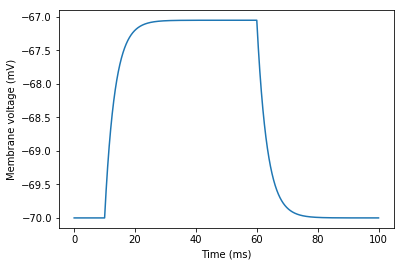

In [8]:
neuron.h.tstop = 100
print "Integration time step: %f ms" % neuron.h.dt

# Initialise arrays
time = neuron.h.Vector()
voltage = neuron.h.Vector()

# Define variable to record
time.record(neuron.h._ref_t)
voltage.record(soma(.5)._ref_v);

# Define membrane potential at time 0
neuron.h.v_init = -70

neuron.h.run()

def plot_time_voltage(time_array, voltage_array, show=True, label=None, constants=[]):
    import matplotlib.pyplot as plt
    import numpy
    plt.plot(time_array, voltage_array, label=label)
    for constant in constants:
        plt.plot(time_array, constant*numpy.ones(len(time_array)))
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane voltage (mV)')
    if show:
        plt.show()

plot_time_voltage(time, voltage)

We see that the membrane potential starts from $-$70 mV, as we set with the *v_init* variable, it stays constant up to 10 ms (because we set $E_{leak}$ = $-$ 70 mV), it depolarises (i.e. becomes more positive) during the stimulus interval and returns to the resting value of $-$70 mV. The transitions are not instantaneous due to the effect of the membrane capacitance.

### Exercise 1
____

Try modify one parameter of the somatic section so that the membrane voltage reaches the steady-state value of ~ $-$ 67 mV faster.

To do so, insert a new cell below, define the new value for this parameter, execute the cell and re-run the simulation.
___

## Adding active channels

Now we can add the sodium and potassium channels to the membrane, and the HH membrane equation will be:
$$C_m \frac{dV}{dt} = - [g_{leak} (V-E_{leak}) + \bar{g}_{Na}m^3(V)h(V)(V-E_{Na}) + \bar{g}_{K}n^4(V)(V-E_{K})] + I_{inj}$$ 

Where $\bar{g}_{Na}$ and $\bar{g}_{K}$ are parameters that we can specify and they represent the density of channels in the membrane. By setting them to a value different from 0, our model will show action potentials.

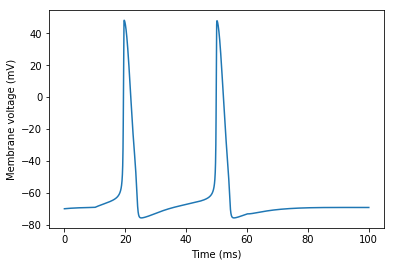

In [9]:
soma.gkbar_hh = 0.01 # in S/cm^2
soma.gnabar_hh = 0.2 # in S/cm^2

neuron.h.run()

plot_time_voltage(time, voltage)

It is also good to keep in mind that NEURON has also default values for simulation temperature. It is important to change this value if you want to model for example to model ion channels in mammals neurons at body temperature.

In [10]:
print r"The defaults simulation temperature is {} !".format(neuron.h.celsius)

The defaults simulation temperature is 6.3 !


## Extending the model with dendrites

We can create additional sections and connect them to the soma. Let's for example add a dendrite.

In [55]:
dend = neuron.h.Section(name='dend')

# Connect one end of the dendrite to the soma
dend.connect(soma)

dend.L = 400 # μm
dend.diam = 2 # μm
dend.nseg = 9 # number of segments in the dendritic section

If you execute the following cell you'll see a schematic version of our model. The output will be printed in your terminal and will appear like that:

|-|       soma(0-1)
  
    `--------|       dend(0-1)

As you may have already understood, locations along section are expressed as normalised values between 0 and 1.

In [56]:
neuron.h.topology(); 

We can add another dendritic section. This time we will specify to which end we want to connect the new section.

In [57]:
dend2 = neuron.h.Section(name='dend2')

# Connect the 0 end of dend2 to the 0 end of dend
dend2.connect(dend,0,0)

dend2.L = 400 # μm
dend2.diam = 2.0 # μm
dend2.nseg = 9 # number of segments in the dendritic section

neuron.h.topology();

Now our model will look like this:

|-|      soma(0-1)
   
    `--------|       dend(0-1)
  
    `------|       dend2(0-1)


### Voltage attenuation along the dendrite

We add the HH mechanism to the dendrites, but we will make them passive.

In [58]:
for sec in [dend, dend2]:
    sec.insert('hh')
    sec.el_hh = -70 # Reversal potential leak current, mV
    sec.gl_hh = 1e-4 # Leak conductance, S/cm^2
    sec.Ra = 100
    sec.gkbar_hh = 0.0
    sec.gnabar_hh = 0.0

Let's verify the desired mechanisms are added to the dendritic sections. If you execute the following cell, you can see this in your terminal:

In [59]:
neuron.h.psection(sec=dend)

1.0

dend { nseg=9  L=200  Ra=100

	soma connect dend (0), 1    
	/* First segment only */    
	insert capacitance { cm=1}    
	insert morphology { diam=2}    
	insert hh { gnabar_hh=0 gkbar_hh=0 gl_hh=0.0005 el_hh=-70}    
	insert na_ion { ena=50}    
	insert k_ion { ek=-77}    
}


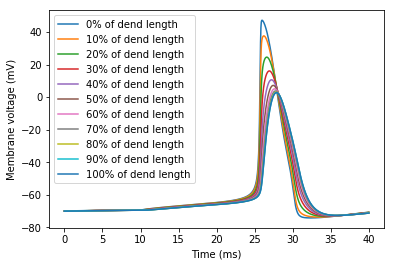

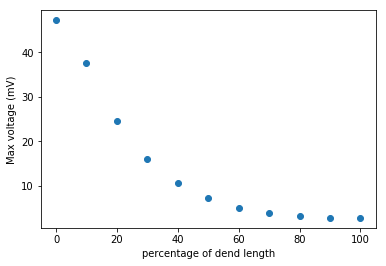

In [60]:
import matplotlib.pyplot as plt
import numpy

voltage_dend = {}

# Span the range of dendritic locations of one of dendrites
distance_range = numpy.arange(0, 1.1, 0.1)
for distance in distance_range:
    voltage_dend[distance] = neuron.h.Vector()
    voltage_dend[distance].record(dend(distance)._ref_v);

neuron.h.v_init = -70    
neuron.h.tstop = 40
neuron.h.run()
plt.figure()
for distance in distance_range:
    plot_time_voltage(time, voltage_dend[distance], show=False, label='%.0f%% of dend length' % (distance*100))
    
plt.legend()
plt.show()

max_voltage_dend = []
for distance in distance_range:
    max_voltage_dend.append(max(voltage_dend[distance]))
    
plt.figure()
plt.plot(distance_range*100, max_voltage_dend, 'o')
plt.xlabel('percentage of dend length')
plt.ylabel('Max voltage (mV)')
plt.show()

### Exercise 2
___
Actually, if we look at the graphs above, the action potential in the dendrite doesn't seem to be very strong: at the end of dendrite (100 % of dend length) the action potential is still visible and its peak is around 0 mV. Can you find at least two parameters that will make the dendritic attenuation more pronounced? Test your hypothesis by changing these parameters and re-running the cell above.
___